In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math
from typing import List, Tuple, Dict
from pathlib import Path
from copy import deepcopy
import hashlib
import concurrent.futures

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from stego import FloatBinary, str_to_bits, bits_to_str, dummy_data_generator

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-upc19reo because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


# Steganography with Neural Network Layers

In this notebook I test how I can hide secrets in a model's parameters and then investigate how it effects the model's performance. A secret can be anything (text, image, video, software) as long as it can be converted to bytes.

In [3]:
# How many bits (LSB) to use from the fraction (mantissa) of the float values
BITS_TO_USE = 16
assert BITS_TO_USE <= 23, "Can't be bigger then 23 bits"

In [4]:
DATA_FOLDER = "/data"

IMAGES_TO_TEST_ON = list(map(str, Path(DATA_FOLDER).glob("**/*.jpg")))
assert len(IMAGES_TO_TEST_ON) > 0, "You'll need some images to test the network performance"

# Load the model

In [5]:
# Any model can be used here
model = tf.keras.applications.ResNet50(include_top=True, weights="imagenet")

2022-02-25 15:28:50.699856: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-25 15:28:51.545033: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30983 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:3e:00.0, compute capability: 7.0


## Data storage capacity of the layers

In [6]:
layers_storage_capacity_mb: Dict[str, int] = {}

for l in model.layers:
    if l.__class__.__name__ == "Conv2D":
        nb_params = np.prod(l.get_weights()[0].shape)
        capacity_in_bytes = np.floor((nb_params * BITS_TO_USE) / 8).astype(int)
        layers_storage_capacity_mb[l.name] = capacity_in_bytes / float(1<<20)

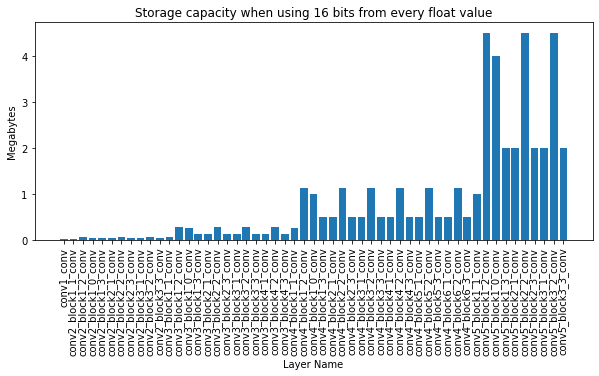

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.bar(layers_storage_capacity_mb.keys(), layers_storage_capacity_mb.values())
ax.tick_params(axis='x', labelrotation = 90)
ax.set_xlabel("Layer Name")
ax.set_ylabel("Megabytes")
ax.set_title(f"Storage capacity when using {BITS_TO_USE} bits from every float value");

# Inspect statistics for selected layers

In [8]:
# Layers with the most storage capacity
# sorted(layers_storage_capacity_mb.items(), key=lambda x: x[1], reverse=True)[:5]

In [9]:
# These layers will be modified to hide the secret

# Selected layers (manual selection)
# layer_names = ["conv5_block1_2_conv", "conv5_block2_2_conv", "conv5_block3_2_conv"]

# All the Conv2D layers
layer_names = list(layers_storage_capacity_mb.keys())

In [10]:
selected_layers_weights = []
for n in layer_names:
    v = model.get_layer(n).weights[0].numpy().ravel()
    selected_layers_weights.extend(v)
selected_layers_weights = np.array(selected_layers_weights)

## Basic statistics

In [11]:
nb_values = len(selected_layers_weights)
min_value = selected_layers_weights.min()
abs_min_value = np.abs(selected_layers_weights).min()
max_value = selected_layers_weights.max()
mean_value = selected_layers_weights.mean()
nb_really_small_values = (abs(selected_layers_weights) < 10e-4).sum()
nb_small_values = (abs(selected_layers_weights) < 10e-3).sum()
nb_negative_values = (selected_layers_weights < 0).sum()
nb_positive_values = (selected_layers_weights > 0).sum()
overall_storage_capacity_bytes = nb_values * BITS_TO_USE / 8
overall_storage_capacity_mb = overall_storage_capacity_bytes // float(1<<20)

In [12]:
print(f"""Stats for {layer_names}
---
Min: {min_value}
Abs. Min {abs_min_value}
Max: {max_value}
Mean: {mean_value}
---
Nb total values: {nb_values}
Nb values < 10e-4: {nb_really_small_values} - {nb_really_small_values/nb_values*100:.4f}%
Nb values < 10e-3: {nb_small_values} - {nb_small_values/nb_values*100:.4f}%
Nb negatives: {nb_negative_values} - {nb_negative_values/nb_values*100:.4f}%
Nb positives: {nb_positive_values} - {nb_positive_values/nb_values*100:.4f}%
---
(Maximum) Storage capacity is {overall_storage_capacity_mb} MB for the {len(layer_names)} layers with the {BITS_TO_USE} bits modification
""")

Stats for ['conv1_conv', 'conv2_block1_1_conv', 'conv2_block1_2_conv', 'conv2_block1_0_conv', 'conv2_block1_3_conv', 'conv2_block2_1_conv', 'conv2_block2_2_conv', 'conv2_block2_3_conv', 'conv2_block3_1_conv', 'conv2_block3_2_conv', 'conv2_block3_3_conv', 'conv3_block1_1_conv', 'conv3_block1_2_conv', 'conv3_block1_0_conv', 'conv3_block1_3_conv', 'conv3_block2_1_conv', 'conv3_block2_2_conv', 'conv3_block2_3_conv', 'conv3_block3_1_conv', 'conv3_block3_2_conv', 'conv3_block3_3_conv', 'conv3_block4_1_conv', 'conv3_block4_2_conv', 'conv3_block4_3_conv', 'conv4_block1_1_conv', 'conv4_block1_2_conv', 'conv4_block1_0_conv', 'conv4_block1_3_conv', 'conv4_block2_1_conv', 'conv4_block2_2_conv', 'conv4_block2_3_conv', 'conv4_block3_1_conv', 'conv4_block3_2_conv', 'conv4_block3_3_conv', 'conv4_block4_1_conv', 'conv4_block4_2_conv', 'conv4_block4_3_conv', 'conv4_block5_1_conv', 'conv4_block5_2_conv', 'conv4_block5_3_conv', 'conv4_block6_1_conv', 'conv4_block6_2_conv', 'conv4_block6_3_conv', 'conv5_bl

# Hide a secret in the layer

## The secret

In [13]:
# secret_to_hide = "I am Gabor and I would like to hide this message"
secret_to_hide = dummy_data_generator.generate_dummy_data(overall_storage_capacity_bytes)
secret_bits = str_to_bits(secret_to_hide)

In [14]:
nb_vals_needed = math.ceil(len(secret_bits) / BITS_TO_USE)

In [15]:
print(f"We need {nb_vals_needed} float values to store the info\nOverall number of values we could use: {nb_values}")

We need 23454912 float values to store the info
Overall number of values we could use: 23454912


## Hide it

### Store the original weights

In [16]:
# This dict holds the original weights for the selected layers
original_weights_dict: dict = {}
for n in layer_names:
    original_weights_dict[n] = deepcopy(model.get_layer(n).weights[0].numpy())

### Create the modified ones

In [17]:
# This dict will hold the modified (secret hidden) weights for the layers
modified_weights_dict = deepcopy(original_weights_dict)
# Index of the last value used in a layer - this is needed because we don't necessary need
# the same number of params for hiding some bits then all the layer parameters
last_index_used_in_layer_dict: dict = {}

# We are modifying the layers in a defined order to know what was changed exactly
# This order is needed when we would like to recover the message

# Variable which tracks the number of values changed so far (used to index the secret message bits)
i = 0

for n in layer_names:
    # Check if we need more values to use to hide the secret, if not then we are done with modifying the layer's weights
    if i >= nb_vals_needed:
        break

    w = modified_weights_dict[n]
    w_shape = w.shape
    w = w.ravel()

    nb_params_in_layer: int = np.prod(w.shape)

    for j in range(nb_params_in_layer):
        # Chunk of data from the secret to hide
        _from_index = i * BITS_TO_USE
        _to_index = _from_index + BITS_TO_USE
        bits_to_hide = secret_bits[_from_index:_to_index]
        bits_to_hide = list(map(bool, bits_to_hide))

        # Modify the defined bits of the float value fraction
        x = FloatBinary(w[j])
        fraction_modified = list(x.fraction)
        if len(bits_to_hide) > 0:
            fraction_modified[-BITS_TO_USE:] = bits_to_hide

        x_modified = x.modify_clone(fraction=tuple(fraction_modified))
        w[j] = x_modified.v

        i += 1
        
        # Check if we need more values to use to hide the secret in the current layer, if not then we are done
        if i >= nb_vals_needed:
            break

    last_index_used_in_layer_dict[n] = j
    w = w.reshape(w_shape)
    modified_weights_dict[n] = w

    print(f"Layer {n} is processed, last index modified: {j}")

Layer conv1_conv is processed, last index modified: 9407
Layer conv2_block1_1_conv is processed, last index modified: 4095
Layer conv2_block1_2_conv is processed, last index modified: 36863
Layer conv2_block1_0_conv is processed, last index modified: 16383
Layer conv2_block1_3_conv is processed, last index modified: 16383
Layer conv2_block2_1_conv is processed, last index modified: 16383
Layer conv2_block2_2_conv is processed, last index modified: 36863
Layer conv2_block2_3_conv is processed, last index modified: 16383
Layer conv2_block3_1_conv is processed, last index modified: 16383
Layer conv2_block3_2_conv is processed, last index modified: 36863
Layer conv2_block3_3_conv is processed, last index modified: 16383
Layer conv3_block1_1_conv is processed, last index modified: 32767
Layer conv3_block1_2_conv is processed, last index modified: 147455
Layer conv3_block1_0_conv is processed, last index modified: 131071
Layer conv3_block1_3_conv is processed, last index modified: 65535
Laye

# Let's test the network and inspect the outputs

## Dataset to test on

In [18]:
print(f"Number of images will be used for testing: {len(IMAGES_TO_TEST_ON)}")

Number of images will be used for testing: 14241


In [19]:
batch_size = 8

In [20]:
def _read_image_from_path(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3, dtype=tf.uint8, expand_animations=False)
    image = tf.image.resize(image, (224, 224))
    return image

dataset = tf.data.Dataset.from_tensor_slices(IMAGES_TO_TEST_ON)
dataset = dataset.map(_read_image_from_path, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

## Predictions made by the model

### Original weights predictions

In [21]:
# Load the original weights to the model layers
for n in layer_names:
    w = original_weights_dict[n]
    model.get_layer(n).set_weights([w, model.get_layer(n).get_weights()[1]])

In [22]:
preds_original = model.predict(dataset)

2022-02-25 15:37:11.971562: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8100


### Modified weights predictions

In [23]:
# Load the modified (secret is hidden) weights to the model layers
for n in layer_names:
    w = modified_weights_dict[n]
    model.get_layer(n).set_weights([w, model.get_layer(n).get_weights()[1]])

In [24]:
preds_modified = model.predict(dataset)

## Differences in predictions

### Raw prediction value comparisons (last layer output)

In [25]:
diff_abs = np.abs(preds_original - preds_modified).ravel()

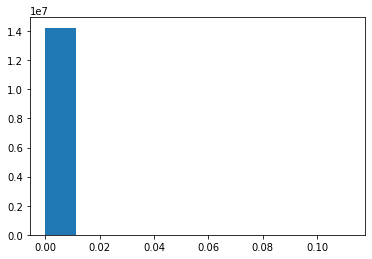

In [26]:
plt.hist(diff_abs[diff_abs > 0]);

In [27]:
print(f"Min abs difference: {diff_abs.min()}")
print(f"Max abs difference: {diff_abs.max()}")
print(f"Number of changed prediction values: {(diff_abs > 0).sum()} / {len(diff_abs)} | {(diff_abs > 0).sum()/len(diff_abs)*100:.4f}%")

Min abs difference: 0.0
Max abs difference: 0.11202079057693481
Number of changed prediction values: 14240972 / 14241000 | 99.9998%


### Change in predicted labels

In [28]:
nb_changed_pred_labels = ((np.argmax(preds_original, 1) - np.argmax(preds_modified, 1)) > 0).sum()

In [29]:
print(f"Changed number of predictions: {nb_changed_pred_labels} / {len(IMAGES_TO_TEST_ON)} | {nb_changed_pred_labels / len(IMAGES_TO_TEST_ON)*100}%")

Changed number of predictions: 146 / 14241 | 1.0252089038691103%


# Recover the secret

For recovering the secret we only need to know the layer names/indices in the model and the bits which we used for the "encoding".

(And of course in a real life scenario we need direct access to the model's weights 😉)

In [30]:
# We store the extracted bits of data here
hidden_data: List[bool] = []

for n in layer_names:
    # Check if the layer was used in hiding the secret or not (e.g.: we could hide the secret in the prev. layers)
    if n not in last_index_used_in_layer_dict.keys():
        continue
    
    # We could get the modified weights directly from the model: model.get_layer(n).get_weights()...
    w = modified_weights_dict[n]
    w_shape = w.shape
    w = w.ravel()
    
    nb_params_in_layer: int = np.prod(w.shape)
    
    for i in range(last_index_used_in_layer_dict[n]+1):
        x = FloatBinary(w[i])
        hidden_bits = x.fraction[-BITS_TO_USE:]
        hidden_data.extend(hidden_bits)
        
    print(f"Layer {n} is processed, bits are extracted")

Layer conv1_conv is processed, bits are extracted
Layer conv2_block1_1_conv is processed, bits are extracted
Layer conv2_block1_2_conv is processed, bits are extracted
Layer conv2_block1_0_conv is processed, bits are extracted
Layer conv2_block1_3_conv is processed, bits are extracted
Layer conv2_block2_1_conv is processed, bits are extracted
Layer conv2_block2_2_conv is processed, bits are extracted
Layer conv2_block2_3_conv is processed, bits are extracted
Layer conv2_block3_1_conv is processed, bits are extracted
Layer conv2_block3_2_conv is processed, bits are extracted
Layer conv2_block3_3_conv is processed, bits are extracted
Layer conv3_block1_1_conv is processed, bits are extracted
Layer conv3_block1_2_conv is processed, bits are extracted
Layer conv3_block1_0_conv is processed, bits are extracted
Layer conv3_block1_3_conv is processed, bits are extracted
Layer conv3_block2_1_conv is processed, bits are extracted
Layer conv3_block2_2_conv is processed, bits are extracted
Layer 

In [31]:
recovered_message: str = bits_to_str(list(map(int, hidden_data)))

In [32]:
chars_to_display = 100
print(f"--Original string:--\n'{secret_to_hide[:chars_to_display]}...'")
print(f"--Recovered string:--\n'{recovered_message[:chars_to_display]}...'")

--Original string:--
'@OrlE33Ul1V %quL{_zs)>zOCp.45|T]p$ynTd++*^B
h3~:mu}G	w|9-@%#N_chN<r"L43S;5Q{)=3Kiq}k"r=4NoG2Cw#g*...'
--Recovered string:--
'@OrlE33Ul1V %quL{_zs)>zOCp.45|T]p$ynTd++*^B
h3~:mu}G	w|9-@%#N_chN<r"L43S;5Q{)=3Kiq}k"r=4NoG2Cw#g*...'


In [33]:
def hash_str(s: str) -> str:
    return hashlib.md5(s.encode("ascii")).hexdigest()

In [34]:
if hash_str(recovered_message) == hash_str(secret_to_hide):
    print("Successful secret hiding and recovery! 🥳")
else:
    print("Recovered message is not the same as the original one 🤨")

Successful secret hiding and recovery! 🥳
